In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nuthangowda","key":"3b15e291dc050f84ec9c5720fcfc2df8"}'}

In [2]:
!mkdir -p ~/.kaggle                                               
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download deepcontractor/200k-short-texts-for-humor-detection

 83% 5.00M/6.00M [00:00<00:00, 22.7MB/s]
100% 6.00M/6.00M [00:00<00:00, 26.9MB/s]


In [4]:
!unzip /content/200k-short-texts-for-humor-detection.zip

Archive:  /content/200k-short-texts-for-humor-detection.zip
  inflating: dataset.csv             


In [6]:
# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# For Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import wordcloud

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

In [7]:
df = pd.read_csv('./dataset.csv')
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


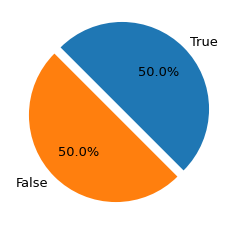

In [8]:
plt.rcParams.update({'font.size':13})
label = ['True', 'False']
count = [len(df[df['humor']==True]),
len(df[df['humor']==False])]

plt.pie(count, labels= label, startangle=-45, explode=[0.1,0], autopct='%.1f%%')
plt.show()

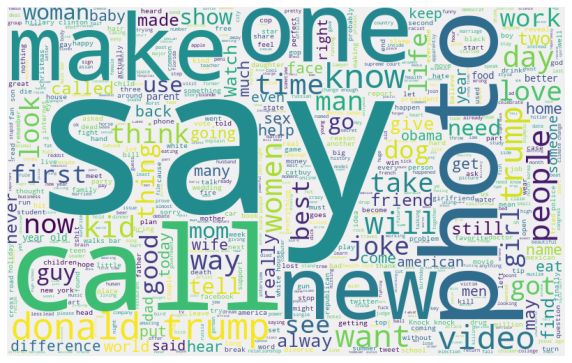

In [9]:
wc = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_words=5000, width=800, height=500, background_color='#f0f0f0').generate(' '.join(txt for txt in df['text']))

fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(wc, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wc)

# Tokenizer

In [12]:
tokenizer = Tokenizer(filters = '"&(),-/:;<=>[\\]_`{|}~\t\n0123456789', lower =True, split=' ')
tokenizer.fit_on_texts(np.array(df['text']))
vocab_size = len(tokenizer.word_index)+1

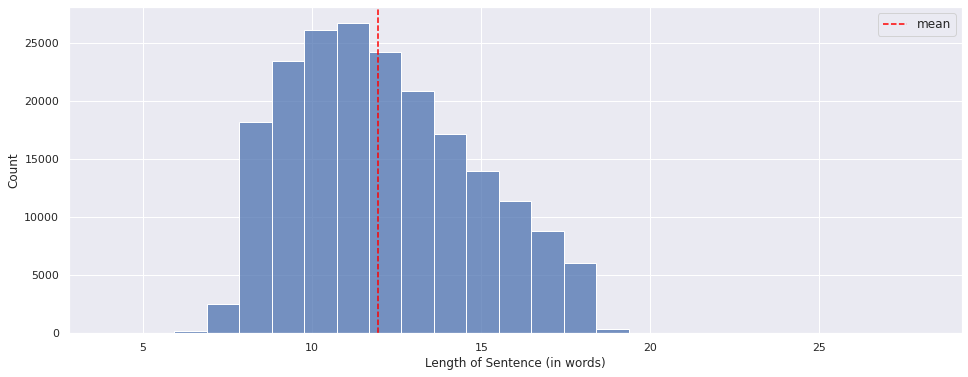

In [13]:
lengths=[]
for x in range(len(df)):
    i = df['text'][x]
    i = tokenizer.texts_to_sequences([i])
    lengths.append(len(i[0]))
lengths = np.array(lengths)
sns.set(rc={'figure.figsize':(16,6)})
fig = sns.histplot(lengths, kde=False, bins=25)
plt.xlabel('Length of Sentence (in words)')
plt.axvline(x=lengths.mean(),
            color='red',ls='--', label="mean")
plt.legend(loc='upper right', prop={'size': 12})
plt.show(fig)

In [14]:
maxlen = 15

In [16]:
df['humor']= df['humor'].apply(lambda x: {True:1, False:0}.get(x))
texts = np.array(df['text'])
texts = tokenizer.texts_to_sequences(texts)
for x in range(len(texts)):
    if len(texts[x])>maxlen:
        texts[x]=texts[x][:maxlen]
texts = pad_sequences(texts, maxlen=maxlen, dtype='float', padding='post', value= 0.0)
texts = np.array(texts)
labels = df['humor']
labels = np.array([float(j) for j in labels])

In [17]:
x_train, x_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=0)

# <span style='color:#4285f4'>|</span> Model</b>

<span style='color:#4285f4'>|</span> Load Embedding Matrix</h2>


In [20]:
!kaggle datasets download mushfirat/glove-pretrained-embeddings/code?select=glove.twitter.27B.100d.txt

100% 4.07G/4.07G [01:05<00:00, 80.6MB/s]
100% 4.07G/4.07G [01:05<00:00, 67.1MB/s]


In [21]:
!unzip /content/glove-pretrained-embeddings.zip

Archive:  /content/glove-pretrained-embeddings.zip
  inflating: glove.42B.300d.txt      
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


In [22]:
embeddings_index = dict()
f = open('/content/glove.twitter.27B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
model = Sequential()
model.add(Input(shape=(maxlen)))
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(64, activation='relu',dropout=0.15, return_sequences=True), merge_mode='concat'))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(LSTM(256, activation='relu',dropout=0.15, return_sequences=False))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           11161500  
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          84480     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 15, 64)           8256      
 ibuted)                                                         
                                                                 
 lstm_1 (LSTM)               (None, 256)               328704    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               6

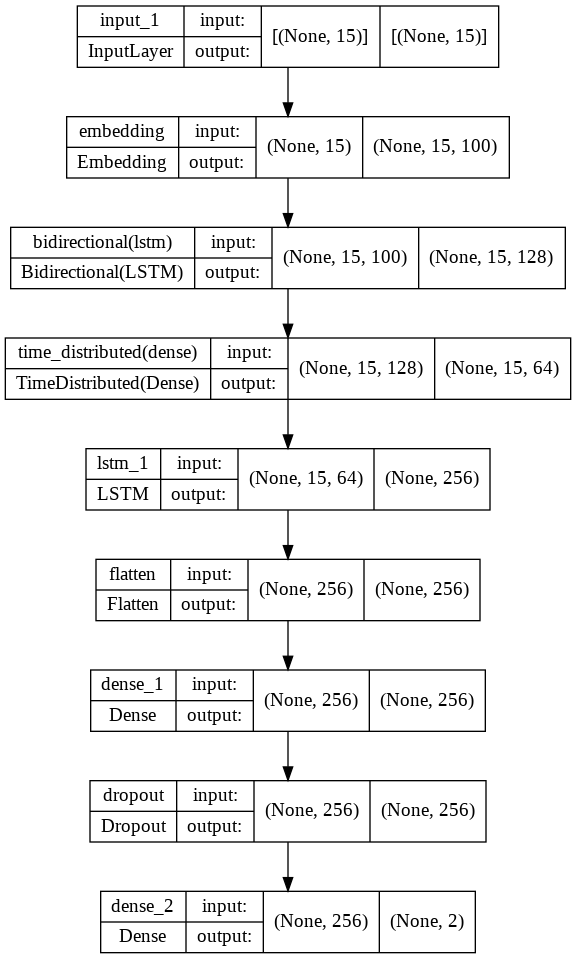

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [30]:
epochs = 20
mc = ModelCheckpoint('model.h5', monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, epochs=epochs, batch_size=4096, validation_data=(x_val, y_val), callbacks=[mc])

Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.6639 - sparse_categorical_accuracy: 0.6166
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.77315, saving model to model.h5
40/40 [==============================] - 128s 3s/step - loss: 0.6639 - sparse_categorical_accuracy: 0.6166 - val_loss: 0.5812 - val_sparse_categorical_accuracy: 0.7732
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.4274 - sparse_categorical_accuracy: 0.8199
Epoch 2: val_sparse_categorical_accuracy improved from 0.77315 to 0.87055, saving model to model.h5
40/40 [==============================] - 117s 3s/step - loss: 0.4274 - sparse_categorical_accuracy: 0.8199 - val_loss: 0.3196 - val_sparse_categorical_accuracy: 0.8705
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.3018 - sparse_categorical_accuracy: 0.8745
Epoch 3: val_sparse_categorical_accuracy improved from 0.87055 to 0.88880, saving model to model.h5
40/40 [=====================

In [31]:
fig = go.Figure(data=go.Scatter(y=history.history['sparse_categorical_accuracy'], mode='lines+markers', name='Train Accuracy'))
fig.add_trace(go.Scatter(y=history.history['val_sparse_categorical_accuracy'], mode='lines+markers', name='Val Accuracy'))

fig.update_layout(
    yaxis_title="Accuracy",
    xaxis_title="Epochs",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)

fig.show()

fig = go.Figure(data=go.Scatter(y=history.history['loss'], mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines+markers', name='Val Loss'))

fig.update_layout(
    yaxis_title="Loss",
    xaxis_title="Epochs",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)

fig.show()

In [33]:
decode_label = {0:'False', 1:'True'}

y_pred = []
y_true = []

pred = model.predict(x_val)
pred = np.argmax(pred, axis=-1)

y = [decode_label[int(i)] for i in y_val]
pred = [decode_label[int(i)] for i in pred]

for i in pred:
    y_pred.append(i)
    
for i in y:
    y_true.append(i)
    
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

       False      0.941     0.929     0.935     19973
        True      0.930     0.942     0.936     20027

    accuracy                          0.936     40000
   macro avg      0.936     0.936     0.936     40000
weighted avg      0.936     0.936     0.936     40000



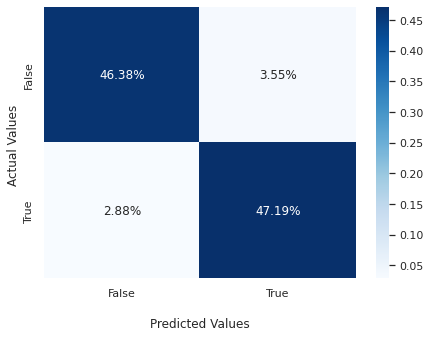

In [34]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [37]:
def predict(text):
    text = tokenizer.texts_to_sequences([text])
    if len(text)>maxlen:
        text=text[:maxlen]
    text = pad_sequences(text, maxlen=maxlen, dtype='float', padding='post', value=0.0)
    text = np.array(text)
    pred = model.predict(text)
    pred = np.argmax(pred, axis=-1)
    decode_label = {0:'False', 1:'True'}
    pred = decode_label[pred[0]]
    return pred

In [35]:
model = load_model('model.h5')

In [38]:
text = "what's the difference between donald trump's hair and a wet racoon"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

Text: what's the difference between donald trump's hair and a wet racoon
Humor detected:  True


In [39]:
text = "Artificial Intelligence is becoming better at language"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

Text: Artificial Intelligence is becoming better at language
Humor detected:  False


In [40]:
text = "people say time is precious but they waste it right after they say it themselves"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

Text: people say time is precious but they waste it right after they say it themselves
Humor detected:  True


In [41]:
text = "place provides very little attention to the customers"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

Text: place provides very little attention to the customers
Humor detected:  False


In [42]:
text = "Im buying coca cola to put cocaine back in it"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

Text: Im buying coca cola to put cocaine back in it
Humor detected:  True
